In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# Cryptocurrency Price Prediction using ARIMA

## Overview
This notebook builds ARIMA (AutoRegressive Integrated Moving Average) models to predict cryptocurrency prices.

### Strategy:
- **Target Variable**: Close price (daily cryptocurrency prices)
- **Model**: ARIMA(p, d, q) - AutoRegressive Integrated Moving Average
- **Parameters**: Automatically determined using auto_arima and manual ACF/PACF analysis
- **Approach**: Train on training data, validate on validation data, evaluate on test data

In [2]:
# Load cryptocurrency data
def load_crypto_data(data_type='train'):
    """Load all cryptocurrency data for train/test/val"""
    cryptos = ['ADA_USD', 'BNB_USD', 'BTC_USD', 'ETH_USD', 'SOL_USD']
    data = {}
    
    for crypto in cryptos:
        file_path = f'data/{data_type}/{crypto}_{data_type}.csv'
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        data[crypto] = df
    
    return data

# Load data
train_data = load_crypto_data('train')
val_data = load_crypto_data('val')
test_data = load_crypto_data('test')

print("Data Loaded Successfully!")
print(f"\nTrain data shape (BTC): {train_data['BTC_USD'].shape}")
print(f"Val data shape (BTC): {val_data['BTC_USD'].shape}")
print(f"Test data shape (BTC): {test_data['BTC_USD'].shape}")
print(f"\nColumns: {list(train_data['BTC_USD'].columns)}")

Data Loaded Successfully!

Train data shape (BTC): (2555, 11)
Val data shape (BTC): (548, 11)
Test data shape (BTC): (548, 11)

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Log_Returns', 'Volume_Change', 'Price_Range', 'Intraday_Return']


In [3]:
# Stationarity Testing with ADF Test
def test_stationarity(timeseries, crypto_name):
    """Test if time series is stationary using ADF test"""
    result = adfuller(timeseries)
    
    print(f"\nADF Test Results for {crypto_name}:")
    print(f"  ADF Statistic: {result[0]:.6f}")
    print(f"  P-value: {result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print(f"  ✓ Series is STATIONARY (p-value = {result[1]:.6f})")
        return True
    else:
        print(f"  ✗ Series is NON-STATIONARY (p-value = {result[1]:.6f})")
        return False

# Test stationarity for each cryptocurrency
print("\n" + "="*80)
print("STATIONARITY TEST (ADF Test)")
print("="*80)

stationarity_results = {}
for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    close_prices = train_data[crypto]['Close'].values
    is_stationary = test_stationarity(close_prices, crypto)
    stationarity_results[crypto] = is_stationary
    
    # Apply differencing if not stationary
    if not is_stationary:
        diff_prices = np.diff(close_prices)
        is_stationary_diff = test_stationarity(diff_prices, f"{crypto} (1st Difference)")
        stationarity_results[f"{crypto}_diff"] = is_stationary_diff


STATIONARITY TEST (ADF Test)

ADF Test Results for BTC_USD:
  ADF Statistic: -0.414415
  P-value: 0.907664
  Critical Values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  ✗ Series is NON-STATIONARY (p-value = 0.907664)

ADF Test Results for BTC_USD (1st Difference):
  ADF Statistic: -7.893312
  P-value: 0.000000
  Critical Values:
    1%: -3.433
    5%: -2.863
    10%: -2.567
  ✓ Series is STATIONARY (p-value = 0.000000)

ADF Test Results for ETH_USD:
  ADF Statistic: -1.379825
  P-value: 0.591909
  Critical Values:
    1%: -3.434
    5%: -2.863
    10%: -2.568
  ✗ Series is NON-STATIONARY (p-value = 0.591909)

ADF Test Results for ETH_USD (1st Difference):
  ADF Statistic: -10.636981
  P-value: 0.000000
  Critical Values:
    1%: -3.434
    5%: -2.863
    10%: -2.568
  ✓ Series is STATIONARY (p-value = 0.000000)

ADF Test Results for BNB_USD:
  ADF Statistic: -1.461925
  P-value: 0.552255
  Critical Values:
    1%: -3.434
    5%: -2.863
    10%: -2.568
  ✗ Series is NON-STATIONARY

In [4]:
# Determine ARIMA Parameters using auto_arima
print("\n" + "="*80)
print("DETERMINING ARIMA PARAMETERS (p, d, q)")
print("="*80)

arima_params = {}

for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    print(f"\n{crypto}")
    print("-" * 40)
    
    close_prices = train_data[crypto]['Close'].values
    
    # Use auto_arima to find optimal parameters
    auto_model = auto_arima(
        close_prices,
        start_p=0, max_p=5,
        start_q=0, max_q=5,
        start_d=0, max_d=2,
        seasonal=False,
        stepwise=True,
        trace=False,
        information_criterion='aic'
    )
    
    order = auto_model.order
    print(f"  Optimal ARIMA Order: {order}")
    print(f"    p (AR): {order[0]}")
    print(f"    d (Differencing): {order[1]}")
    print(f"    q (MA): {order[2]}")
    
    arima_params[crypto] = order


DETERMINING ARIMA PARAMETERS (p, d, q)

BTC_USD
----------------------------------------
  Optimal ARIMA Order: (1, 1, 0)
    p (AR): 1
    d (Differencing): 1
    q (MA): 0

ETH_USD
----------------------------------------
  Optimal ARIMA Order: (1, 1, 0)
    p (AR): 1
    d (Differencing): 1
    q (MA): 0

BNB_USD
----------------------------------------
  Optimal ARIMA Order: (5, 1, 2)
    p (AR): 5
    d (Differencing): 1
    q (MA): 2

ADA_USD
----------------------------------------
  Optimal ARIMA Order: (1, 1, 1)
    p (AR): 1
    d (Differencing): 1
    q (MA): 1

SOL_USD
----------------------------------------
  Optimal ARIMA Order: (0, 1, 0)
    p (AR): 0
    d (Differencing): 1
    q (MA): 0



ACF AND PACF PLOTS



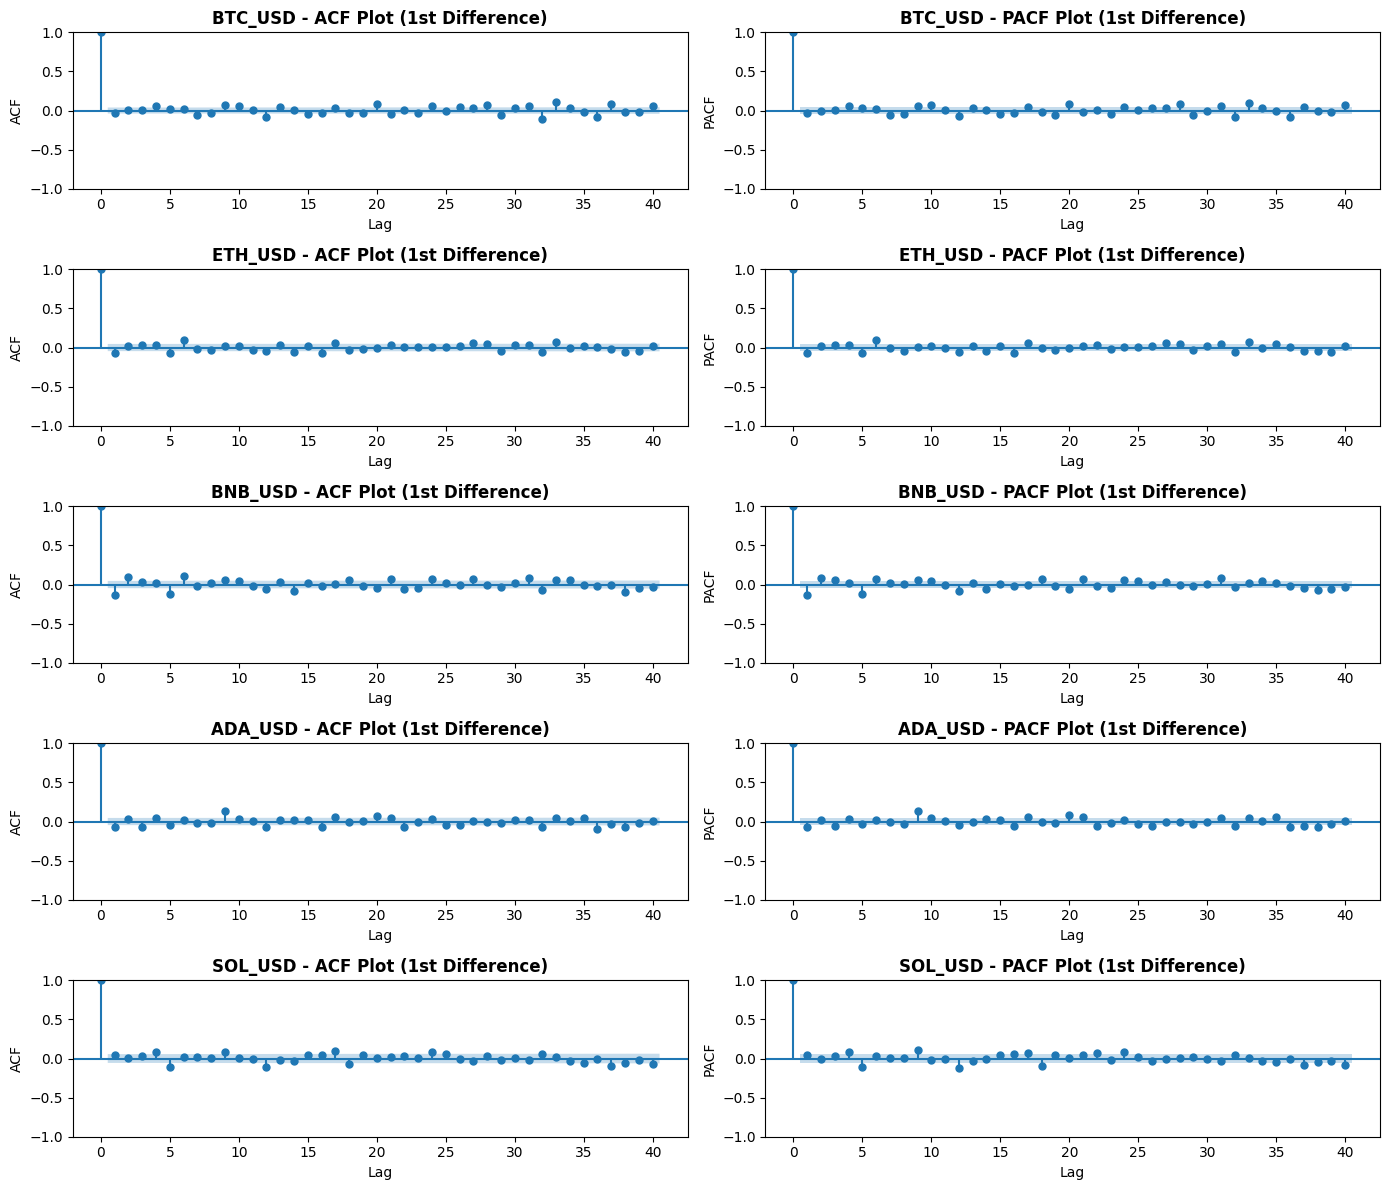

ACF and PACF plots saved as 'arima_acf_pacf_plots.png'


In [5]:
# Plot ACF and PACF for parameter identification
print("\n" + "="*80)
print("ACF AND PACF PLOTS")
print("="*80 + "\n")

fig, axes = plt.subplots(5, 2, figsize=(14, 12))

for idx, crypto in enumerate(['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']):
    close_prices = train_data[crypto]['Close'].values
    
    # Apply first differencing
    diff_prices = np.diff(close_prices)
    
    # ACF plot
    plot_acf(diff_prices, lags=40, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{crypto} - ACF Plot (1st Difference)', fontweight='bold')
    axes[idx, 0].set_xlabel('Lag')
    axes[idx, 0].set_ylabel('ACF')
    
    # PACF plot
    plot_pacf(diff_prices, lags=40, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{crypto} - PACF Plot (1st Difference)', fontweight='bold')
    axes[idx, 1].set_xlabel('Lag')
    axes[idx, 1].set_ylabel('PACF')

plt.tight_layout()
plt.savefig('arima_acf_pacf_plots.png', dpi=100, bbox_inches='tight')
plt.show()

print("ACF and PACF plots saved as 'arima_acf_pacf_plots.png'")

In [13]:
# Build and Train ARIMA Models (Combined Train + Val)
print("\n" + "="*80)
print("BUILDING AND TRAINING ARIMA MODELS")
print("="*80)

arima_models = {}

for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    print(f"\n{'='*60}")
    print(f"Training ARIMA model for {crypto}")
    print(f"{'='*60}")
    
    # Combine training + validation data for better model fitting
    train_prices = train_data[crypto]['Close'].values
    val_prices = val_data[crypto]['Close'].values
    combined_prices = np.concatenate([train_prices, val_prices])
    
    test_prices = test_data[crypto]['Close'].values
    
    # Get ARIMA parameters
    order = arima_params[crypto]
    
    # Fit ARIMA model on combined train+val data
    try:
        arima_model = ARIMA(combined_prices, order=order)
        fitted_model = arima_model.fit()
        
        print(f"✓ Model fitted successfully")
        print(f"  Order: {order}")
        print(f"  AIC: {fitted_model.aic:.2f}")
        print(f"  BIC: {fitted_model.bic:.2f}")
        print(f"  Training data size: {len(combined_prices)}")
        print(f"  Test data size: {len(test_prices)}")
        
        arima_models[crypto] = {
            'model': fitted_model,
            'order': order,
            'combined_prices': combined_prices,
            'test_prices': test_prices
        }
        
    except Exception as e:
        print(f"✗ Error fitting model: {str(e)}")


BUILDING AND TRAINING ARIMA MODELS

Training ARIMA model for BTC_USD
✓ Model fitted successfully
  Order: (1, 1, 0)
  AIC: 50278.44
  BIC: 50290.52
  Training data size: 3103
  Test data size: 548

Training ARIMA model for ETH_USD
✓ Model fitted successfully
  Order: (1, 1, 0)
  AIC: 25386.14
  BIC: 25397.54
  Training data size: 2216
  Test data size: 392

Training ARIMA model for BNB_USD
✓ Model fitted successfully
  Order: (5, 1, 2)
  AIC: 17121.13
  BIC: 17166.75
  Training data size: 2216
  Test data size: 392

Training ARIMA model for ADA_USD
✓ Model fitted successfully
  Order: (1, 1, 1)
  AIC: -7466.06
  BIC: -7448.95
  Training data size: 2216
  Test data size: 392

Training ARIMA model for SOL_USD
✓ Model fitted successfully
  Order: (0, 1, 0)
  AIC: 8495.93
  BIC: 8501.22
  Training data size: 1466
  Test data size: 259


In [17]:
# Evaluate ARIMA Models on Test Set - Backtesting Approach
print("\n" + "="*80)
print("EVALUATING ARIMA MODELS ON TEST SET (Backtesting)")
print("="*80 + "\n")

def evaluate_arima_backtesting(fitted_model, combined_prices, test_prices, order):
    """Evaluate ARIMA model using backtesting approach"""
    predictions = []
    history = list(combined_prices)
    
    print(f"  Progress: ", end='', flush=True)
    for i, test_value in enumerate(test_prices):
        if i % max(1, len(test_prices)//5) == 0:
            print(f"{int((i/len(test_prices))*100)}%... ", end='', flush=True)
        
        # Fit model on history
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        
        # Forecast one step ahead
        forecast = model_fit.forecast(steps=1).values[0] if hasattr(model_fit.forecast(steps=1), 'values') else float(model_fit.forecast(steps=1)[0])
        predictions.append(forecast)
        
        # Add actual test value to history
        history.append(test_value)
    
    print("100%")
    predictions = np.array(predictions)
    
    # Calculate metrics
    mse = mean_squared_error(test_prices, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_prices, predictions)
    r2 = r2_score(test_prices, predictions)
    
    return {
        'y_pred': predictions,
        'y_actual': test_prices,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

evaluation_results = {}

for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    print(f"\nEvaluating {crypto}:")
    fitted_model = arima_models[crypto]['model']
    combined_prices = arima_models[crypto]['combined_prices']
    test_prices = arima_models[crypto]['test_prices']
    order = arima_params[crypto]
    
    eval_res = evaluate_arima_backtesting(fitted_model, combined_prices, test_prices, order)
    evaluation_results[crypto] = eval_res
    
    print(f"  RMSE: ${eval_res['rmse']:.6f}")
    print(f"  MAE:  ${eval_res['mae']:.6f}")
    print(f"  R² Score: {eval_res['r2']:.4f}")


EVALUATING ARIMA MODELS ON TEST SET (Backtesting)


Evaluating BTC_USD:
  Progress: 0%... 19%... 39%... 59%... 79%... 99%... 100%
  RMSE: $1570.394549
  MAE:  $1031.366803
  R² Score: 0.9939

Evaluating ETH_USD:
  Progress: 0%... 19%... 39%... 59%... 79%... 99%... 100%
  RMSE: $101.552596
  MAE:  $71.608743
  R² Score: 0.9632

Evaluating BNB_USD:
  Progress: 0%... 19%... 39%... 59%... 79%... 99%... 100%
  RMSE: $16.977900
  MAE:  $11.571176
  R² Score: 0.9825

Evaluating ADA_USD:
  Progress: 0%... 19%... 39%... 59%... 79%... 99%... 100%
  RMSE: $0.028571
  MAE:  $0.018273
  R² Score: 0.9803

Evaluating SOL_USD:
  Progress: 0%... 19%... 39%... 59%... 78%... 98%... 100%
  RMSE: $6.748338
  MAE:  $5.180831
  R² Score: 0.9558


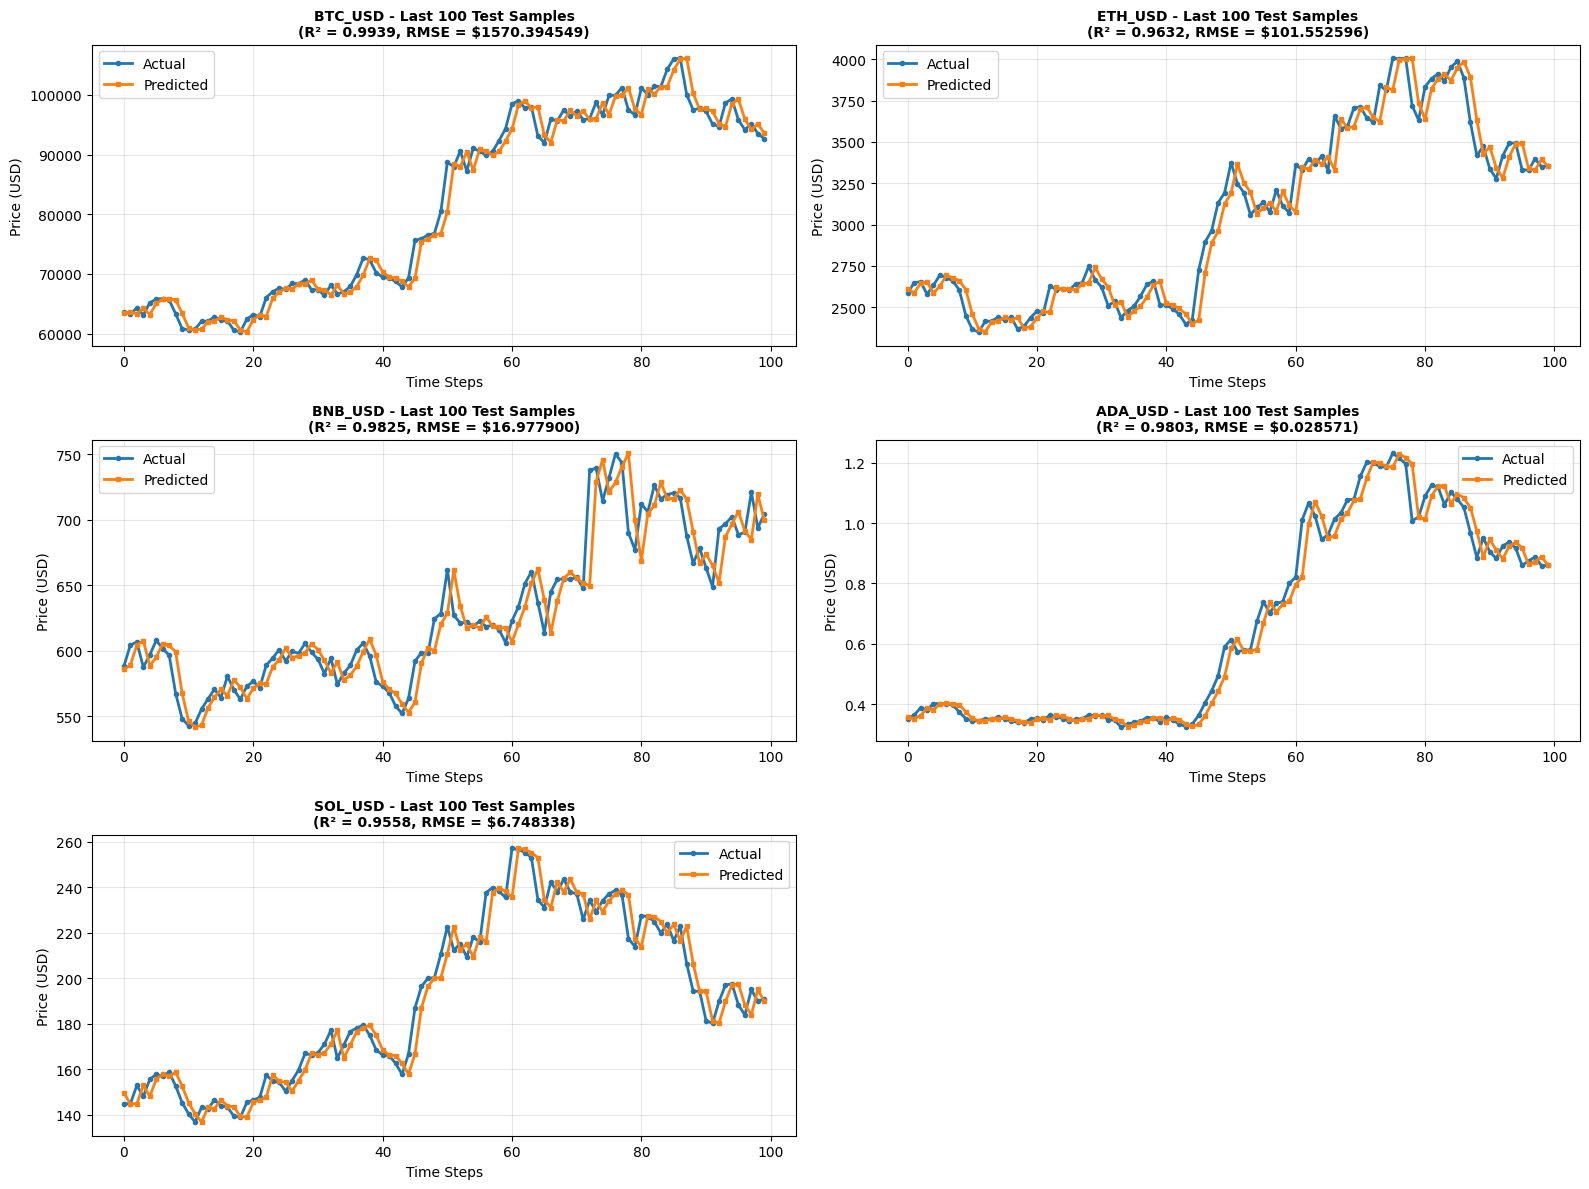

Visualization saved as 'arima_predictions.png'


In [18]:
# Visualize ARIMA Predictions vs Actual Values
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, crypto in enumerate(['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']):
    ax = axes[idx]
    eval_res = evaluation_results[crypto]
    
    # Plot last 100 predictions for clarity
    ax.plot(eval_res['y_actual'][-100:], label='Actual', linewidth=2, marker='o', markersize=3)
    ax.plot(eval_res['y_pred'][-100:], label='Predicted', linewidth=2, marker='s', markersize=3)
    
    ax.set_title(f'{crypto} - Last 100 Test Samples\n(R² = {eval_res["r2"]:.4f}, RMSE = ${eval_res["rmse"]:.6f})', 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('arima_predictions.png', dpi=100, bbox_inches='tight')
plt.show()

print("Visualization saved as 'arima_predictions.png'")

In [19]:
# Model Performance Comparison
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80 + "\n")

# Create a summary dataframe
metrics_summary = []
for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    eval_res = evaluation_results[crypto]
    order = arima_params[crypto]
    metrics_summary.append({
        'Cryptocurrency': crypto,
        'ARIMA Order': f"({order[0]},{order[1]},{order[2]})",
        'RMSE': eval_res['rmse'],
        'MAE': eval_res['mae'],
        'R² Score': eval_res['r2']
    })

summary_df = pd.DataFrame(metrics_summary)
print(summary_df.to_string(index=False))
print("\n")

# Find best models for each metric
best_r2_crypto = summary_df.loc[summary_df['R² Score'].idxmax(), 'Cryptocurrency']
best_r2_score = summary_df.loc[summary_df['R² Score'].idxmax(), 'R² Score']

best_rmse_crypto = summary_df.loc[summary_df['RMSE'].idxmin(), 'Cryptocurrency']
best_rmse_value = summary_df.loc[summary_df['RMSE'].idxmin(), 'RMSE']

best_mae_crypto = summary_df.loc[summary_df['MAE'].idxmin(), 'Cryptocurrency']
best_mae_value = summary_df.loc[summary_df['MAE'].idxmin(), 'MAE']

print("="*80)
print("BEST MODELS BY METRIC")
print("="*80)
print(f"\n🏆 BEST R² SCORE (Higher is Better): {best_r2_crypto}")
print(f"   R² Score: {best_r2_score:.4f}")
print(f"   Interpretation: Explains {best_r2_score*100:.2f}% of variance in price movements\n")

print(f"🏆 BEST RMSE (Lower is Better): {best_rmse_crypto}")
print(f"   RMSE: ${best_rmse_value:.6f}")
print(f"   Interpretation: Average prediction error is ${best_rmse_value:.6f}\n")

print(f"🏆 BEST MAE (Lower is Better): {best_mae_crypto}")
print(f"   MAE: ${best_mae_value:.6f}")
print(f"   Interpretation: Average absolute prediction error is ${best_mae_value:.6f}\n")

# Overall best model (based on R² score as primary metric)
print("="*80)
print(f"🎯 OVERALL BEST MODEL: {best_r2_crypto}")
print("="*80)
print(f"\nThe {best_r2_crypto} model is the best performer with:")
print(f"  • R² Score: {best_r2_score:.4f} (Best among all models)")
print(f"  • RMSE: ${evaluation_results[best_r2_crypto]['rmse']:.6f}")
print(f"  • MAE: ${evaluation_results[best_r2_crypto]['mae']:.6f}")
print(f"  • ARIMA Order: {arima_params[best_r2_crypto]}")
print(f"\nRecommendation: Use the {best_r2_crypto} model for production cryptocurrency price predictions.")


MODEL PERFORMANCE COMPARISON

Cryptocurrency ARIMA Order        RMSE         MAE  R² Score
       BTC_USD     (1,1,0) 1570.394549 1031.366803  0.993927
       ETH_USD     (1,1,0)  101.552596   71.608743  0.963163
       BNB_USD     (5,1,2)   16.977900   11.571176  0.982541
       ADA_USD     (1,1,1)    0.028571    0.018273  0.980257
       SOL_USD     (0,1,0)    6.748338    5.180831  0.955824


BEST MODELS BY METRIC

🏆 BEST R² SCORE (Higher is Better): BTC_USD
   R² Score: 0.9939
   Interpretation: Explains 99.39% of variance in price movements

🏆 BEST RMSE (Lower is Better): ADA_USD
   RMSE: $0.028571
   Interpretation: Average prediction error is $0.028571

🏆 BEST MAE (Lower is Better): ADA_USD
   MAE: $0.018273
   Interpretation: Average absolute prediction error is $0.018273

🎯 OVERALL BEST MODEL: BTC_USD

The BTC_USD model is the best performer with:
  • R² Score: 0.9939 (Best among all models)
  • RMSE: $1570.394549
  • MAE: $1031.366803
  • ARIMA Order: (1, 1, 0)

Recommendatio

In [20]:
# Save ARIMA Predictions to CSV
import os

# Create directory for saving predictions
output_dir = 'ARIMA_Model_Predictions'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("\n" + "="*80)
print("SAVING ARIMA PREDICTIONS TO CSV")
print("="*80 + "\n")

for crypto in evaluation_results.keys():
    eval_res = evaluation_results[crypto]
    test_prices = test_data[crypto]['Close'].values
    
    # Create a dataframe with test data and predictions
    data_to_save = {
        'Sample_Index': range(len(eval_res['y_actual'])),
        'Actual_Price': eval_res['y_actual'],
        'Predicted_Price': eval_res['y_pred'],
        'Absolute_Error': np.abs(eval_res['y_actual'] - eval_res['y_pred']),
        'Percentage_Error': (np.abs(eval_res['y_actual'] - eval_res['y_pred']) / eval_res['y_actual']) * 100
    }
    
    prediction_df = pd.DataFrame(data_to_save)
    
    # Save to CSV
    filename = f'{output_dir}/arima_model_predictions_{crypto.replace("_USD", "").lower()}.csv'
    prediction_df.to_csv(filename, index=False)
    
    print(f"✓ Saved {crypto}: {filename}")
    print(f"  Rows: {len(prediction_df)}")
    print(f"  ARIMA Order: {arima_params[crypto]}")
    print(f"  Mean Absolute Error: ${prediction_df['Absolute_Error'].mean():.6f}")
    print(f"  Mean Percentage Error: {prediction_df['Percentage_Error'].mean():.4f}%\n")

print("="*80)
print(f"All ARIMA predictions saved to '{output_dir}' directory!")
print("="*80)


SAVING ARIMA PREDICTIONS TO CSV

✓ Saved BTC_USD: ARIMA_Model_Predictions/arima_model_predictions_btc.csv
  Rows: 548
  ARIMA Order: (1, 1, 0)
  Mean Absolute Error: $1031.366803
  Mean Percentage Error: 1.7731%

✓ Saved ETH_USD: ARIMA_Model_Predictions/arima_model_predictions_eth.csv
  Rows: 392
  ARIMA Order: (1, 1, 0)
  Mean Absolute Error: $71.608743
  Mean Percentage Error: 2.3831%

✓ Saved BNB_USD: ARIMA_Model_Predictions/arima_model_predictions_bnb.csv
  Rows: 392
  ARIMA Order: (5, 1, 2)
  Mean Absolute Error: $11.571176
  Mean Percentage Error: 2.1890%

✓ Saved ADA_USD: ARIMA_Model_Predictions/arima_model_predictions_ada.csv
  Rows: 392
  ARIMA Order: (1, 1, 1)
  Mean Absolute Error: $0.018273
  Mean Percentage Error: 3.2336%

✓ Saved SOL_USD: ARIMA_Model_Predictions/arima_model_predictions_sol.csv
  Rows: 259
  ARIMA Order: (0, 1, 0)
  Mean Absolute Error: $5.180831
  Mean Percentage Error: 3.1473%

All ARIMA predictions saved to 'ARIMA_Model_Predictions' directory!
